# Neural Network Quantum State



In [1]:
import os
import json

import matplotlib.pyplot as plt
import jax.numpy as jnp
import ray
import netket as nk
import netket.nn as nn
import netket.experimental

from ray import tune
from IPython.display import display

# Our source code
from model import OurModel, setup_problem, setup_model, ray_train_loop, get_ground_state

In [2]:
os.environ["JAX_PLATFORM_NAME"] = "gpu" # or gpu
# os.environ["RAY_PICKLE_VERBOSE_DEBUG"] = "1" # RAY DEBUG
# os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"  # force gpu w/o right drivers

skip_training = False
print(f'{nk.utils.mpi.available=}')

# Force detecting GPU in WSL
ray.shutdown()
ray.init(num_gpus=1)

nk.utils.mpi.available=True


RayContext(dashboard_url='', python_version='3.9.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '192.168.43.245', 'raylet_ip_address': '192.168.43.245', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-14_11-20-08_004722_5361/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-14_11-20-08_004722_5361/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-14_11-20-08_004722_5361', 'metrics_export_port': 49687, 'gcs_address': '192.168.43.245:58579', 'address': '192.168.43.245:58579', 'node_id': '25608f64f6204e3b18076678f5d6f239e66d160f23a10aa903a0a49e'})

### Hyperparameter tuning
Use this to select the best `hyperparameters`.

In [3]:
if not skip_training:
    from ray.tune.suggest.hyperopt import HyperOptSearch
    
    search_space = {
        'model': {
            'alpha': tune.randint(1, 3+1), # last value exclusive
        },
        # 'activation': tune.choice(['tanh', 'sigmoid']),
        'learning_rate': tune.uniform(0.0, 0.1),
        'n_epochs': 300, #tune.qrandint(100, 300, 50),
        'n_samples': 1008, #tune.qrandint(100, 1000, 100),
    }
    
    metric = "energy_error"
    mode = "min"

    hyperopt_search = HyperOptSearch(metric=metric, mode=mode)
    hyper_band_scheduler = tune.schedulers.ASHAScheduler(
        metric=metric,
        mode=mode,
        max_t=search_space['n_epochs'].max_value if isinstance(search_space['n_epochs'], tune.sample.Sampler) else search_space['n_epochs'],
        grace_period=20
    )

    analysis = tune.run(
        ray_train_loop,
        config=search_space,
        progress_reporter=tune.JupyterNotebookReporter(True, [metric]),
        scheduler=hyper_band_scheduler,
        resources_per_trial={"cpu": 6, 'gpu': 1/2},
        search_alg=hyperopt_search,
        num_samples=5,
        resume='AUTO',
        # metric=metric,
        # mode=mode,
    )

Trial name,status,loc,learning_rate,model/alpha,n_epochs,n_samples,energy_error
ray_train_loop_5f389ce8,RUNNING,192.168.36.171:2559,0.0548154,2,300,1008,
ray_train_loop_6fe883fe,RUNNING,192.168.36.171:3138,0.0978837,3,300,1008,
ray_train_loop_0327917c,PENDING,,0.013007,1,300,1008,
ray_train_loop_5dc189b0,TERMINATED,192.168.36.171:1616,0.0430873,2,300,1008,4.11905
ray_train_loop_5f369e2a,TERMINATED,192.168.36.171:1758,0.0963717,1,300,1008,1.06581e-14


### Select best model parameters

In [3]:
# TODO select best

hyperparams = {
    'model': {
        'alpha': 1
    },
    'learning_rate': 0.09,
    'n_epochs': 300,
    'n_samples': 1008,
}
file_name = 'best_params'

H, hi = setup_problem()
vstate, model, trainer = setup_model(H, hi, hyperparams)
display(f'{vstate.n_parameters=}')

'vstate.n_parameters=480'

Train with the best parameters.

In [4]:
if not skip_training:
    log = nk.logging.JsonLog(file_name)  # save error per iteration in JSON
    trainer.run(n_iter=hyperparams['n_epochs'], out=log)

    energy = vstate.expect(H)
    energy_analytic = get_ground_state(H)
    error = abs((energy.mean - energy_analytic) / energy_analytic)
    print("Optimized energy and relative error: ", energy, error)
    
    data = log.data

Load trained model if `skip_training=True`

In [9]:
if skip_training:

    data = json.load(open(f"{file_name}.log"))
    # Load `vstate`, i.e. |ket> from file
    vstate.variables = netket.experimental.vqs.variables_from_file(f"{file_name}.mpack", vstate.variables)

    energy_analytic = get_ground_state(H)

## Results

Text(0, 0.5, 'Energy')

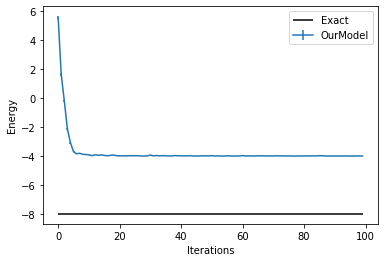

In [20]:
plt.errorbar(data["Energy"]["iters"], data["Energy"]["Mean"]['real'], yerr=data["Energy"]['Sigma'], label="OurModel")
plt.hlines([energy_analytic], xmin=0, xmax=max(data["Energy"]["iters"]), color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

### Wavefunctions

In [22]:
ket = vstate.to_array()

ket

DeviceArray([ 1.44608614e-12+5.49106834e-12j,
              1.73644202e-12+2.59731903e-12j,
              3.21173001e-10+2.82244345e-10j, ...,
             -9.28134143e-13+7.73797316e-13j,
              5.97939600e-12+8.71409924e-11j,
              2.65246828e-13+4.14796369e-12j], dtype=complex128)

In [23]:
# get quantum geometric tensor of state
# https://github.com/netket/netket/blob/2a7dded3db4705099d4de5450006b46b32ce34ca/netket/optimizer/qgt/qgt_onthefly_logic.py
qgt = vstate.quantum_geometric_tensor()
qgt

QGTOnTheFly(diag_shift=0.0)

In [24]:
QGT = qgt.to_dense()
jnp.imag(QGT)

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)